In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-expression/fer2013.csv
/kaggle/input/facial-expression/fer2013/fer2013.csv


# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import imageio as image

# CNN imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, losses, initializers, regularizers, optimizers, metrics
from tensorflow.keras.utils import to_categorical

seed = 42
np.random.seed(seed)


# Constants

In [3]:
# CONSTANTS
path = '/kaggle/input/facial-expression/'
img_shape = 48
label_map = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Read Data

In [4]:
df = pd.read_csv(path + 'fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
# get the images from pixels feature and convert it to numpy array
def get_train_data(df):
    x = []

    train = df['pixels'].to_numpy()

    for i in range(len(train)):
        x.append(train[i].split(' '))

    x = np.array(x)
    x = x.astype('float32').reshape(len(train), 48, 48, 1)

    return x

In [84]:
X = get_train_data(df) / 255. # get the X data and scale it by dividing 255.0 to range it [0 - 1]

y = df['emotion'].values.astype('int') # convert emotion values into int
y = to_categorical(y) # convert ordinal labels to categorical labels

X.shape, y.shape

((35887, 48, 48, 1), (35887, 7))

# EDA

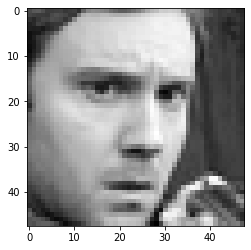

In [7]:
plt.imshow(X[0], cmap='gray') 

In [8]:
# Missign Values
df.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

<AxesSubplot:xlabel='emotion', ylabel='count'>

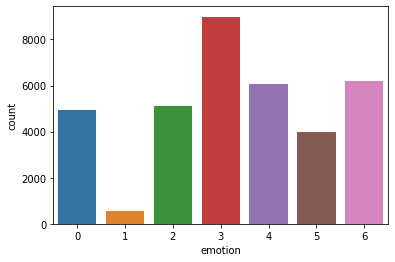

In [9]:
# show if data is balanced or imbalanced
sns.countplot(x='emotion', data = df, )

# Split Train and Test

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = .3, random_state = seed)

# split 10 test images for prediction
x_valid, x_test, y_valid, y_test   = train_test_split(x_valid, y_valid, test_size = 10, random_state = seed)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((25120, 48, 48, 1),
 (25120, 7),
 (10757, 48, 48, 1),
 (10757, 7),
 (10, 48, 48, 1),
 (10, 7))

# Build Functional API Model

In [31]:
# build conv2d block with avgPool2D layers
def conv_block(layer_in, n_filters, filter_size = 3, padding= 'same', n_blocks = 2, dropout = False):
    for i in range(n_blocks):
        layer_in = layers.Conv2D(n_filters, filter_size, activation='relu', padding=padding)(layer_in)
        
    layer_in = layers.AveragePooling2D()(layer_in)
    
    if dropout == True:
        layer_in = layers.Dropout(.2)(layer_in)
        
    return layer_in

In [33]:
base = layers.Input(shape=(img_shape, img_shape,1))
x = conv_block(base, 32, 3)
x = conv_block(x, 64, 3, )
x = conv_block(x, 128, 3, n_blocks=2, dropout=True)
x = conv_block(x, 256, 3, n_blocks=2, dropout=True)

x = layers.Flatten()(x)
x = layers.Dense(32)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Dense(64)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

x = layers.Dense(7, activation = 'softmax')(x)

model = keras.models.Model(inputs = base, outputs=x)

model.compile(optimizer=optimizers.Adam(.001), loss = losses.categorical_crossentropy, metrics=[metrics.CategoricalAccuracy()])

model.summary() 

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 48, 48, 1)]       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
average_pooling2d_18 (Averag (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 24, 24, 64)        36928     
_________________________________________________________________
average_pooling2d_19 (Averag (None, 12, 12, 64)        0   

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

EPOCHS = 100
BATCH_SIZE = 60

# early_stop = EarlyStopping(monitor='val_loss', patience=10, mode='min')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=.5, min_lr=.0001, patience=1, verbose = 1, mode = 'min')
model_ckp = ModelCheckpoint('my_best_model.h5', monitor='val_loss', save_best_only=True, mode='min')


# set the saved weights (if exist)
# model.set_weights(best_weights)

history = model.fit(x=x_train, 
                    y=y_train, 
                    epochs=EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    callbacks=[lr_reduce, model_ckp],  # early_stop
                    validation_data=(x_valid, y_valid), 
                    verbose = 1, 
                    steps_per_epoch=len(x_train)//BATCH_SIZE
                   )


Epoch 1/100
418/418 [==============================] - 7s 14ms/step - loss: 1.8230 - categorical_accuracy: 0.2425 - val_loss: 1.8228 - val_categorical_accuracy: 0.2168
Epoch 2/100
418/418 [==============================] - 5s 12ms/step - loss: 1.7137 - categorical_accuracy: 0.3136 - val_loss: 1.7775 - val_categorical_accuracy: 0.2937
Epoch 3/100
418/418 [==============================] - 5s 13ms/step - loss: 1.5868 - categorical_accuracy: 0.3813 - val_loss: 1.5287 - val_categorical_accuracy: 0.3956
Epoch 4/100
418/418 [==============================] - 5s 12ms/step - loss: 1.4759 - categorical_accuracy: 0.4255 - val_loss: 1.4220 - val_categorical_accuracy: 0.4524
Epoch 5/100
418/418 [==============================] - 6s 13ms/step - loss: 1.3891 - categorical_accuracy: 0.4632 - val_loss: 1.4392 - val_categorical_accuracy: 0.4388
Epoch 6/100
418/418 [==============================] - 5s 12ms/step - loss: 1.3055 - categorical_accuracy: 0.4988 - val_loss: 1.2950 - val_categorical_accuracy:

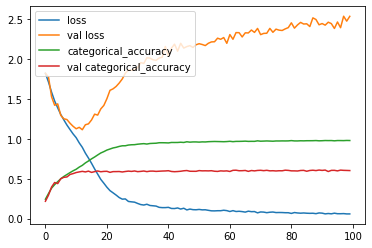

In [35]:
hist = history.history

plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label='val loss')
plt.plot(hist['categorical_accuracy'], label='categorical_accuracy')
plt.plot(hist['val_categorical_accuracy'], label='val categorical_accuracy')
plt.legend()

In [36]:
# Evalute the Model
model.evaluate(x_valid, y_valid)

337/337 [==============================] - 1s 4ms/step - loss: 2.5383 - categorical_accuracy: 0.6023


[2.5383083820343018, 0.6023054718971252]

# Predictions

**Let's predict the model using x_test** (the 10 images splitted out of training to test the model)

In [81]:
# build method to predict the image 
def predict_image(img):
    img = np.expand_dims(img, axis =0)
    y_pred = model.predict(img)
    
    y_pred = np.argmax(y_pred, axis =1)

    return y_pred


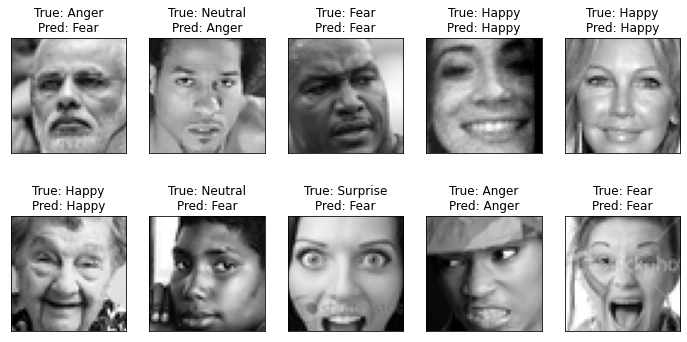

In [83]:
# loop over the x_test and predict each image and show the true and predicted result
plt.figure(figsize=(12,6))
for i, img in enumerate(x_test):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img, cmap='gray')

    y_pred = label_map[predict_image(img)[0]]
    
    y_true = label_map[np.argmax(y_test[i])]
    
    plt.title(f'True: {y_true}\nPred: {y_pred}')
    plt.yticks([])
    plt.xticks([])
    

**Happy for any feedback, thanks** 👍